<a href="https://colab.research.google.com/github/Skye-Zhangg/Homework/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1**
In this part you will implement a neural network from scratch. You cannot use any existing
Deep Learning Framework. You can utilize NumPy and Pandas libraries to perform efficient
calculations. Refer to Lecture 5 slides for details on computations required.
Write a Class called NeuralNetwork that has at least the following methods (you are free to add
your own methods too):\
a. Initialization method.\
b. Forward propagation method that performs forward propagation calculations.\
c. Backward propagation method that implements the backpropagation algorithm discussed in class.\
d. Train method that includes the code for gradient descent.\
e. Cost method that calculates the loss function.\
f. Predict method that calculates the predictions for the test set.\
Test your NeuralNetwork Class with the dataset you selected. If the dataset is big, you may notice inefficiencies in runtime. Try incorporating different versions of gradient descent to improve that (Minibatch, Stochastic etc.). You may choose to use only a subset of your data for this task (or any other technique). Explain which technique you followed and why.

For this homework, I used the Digits dataset from scikit-learn. The dataset contains 1,797 grayscale images of handwritten digits (0–9). Each image is 8×8 pixels and is flattened into a 64-dimensional feature vector. The task is a supervised multi-class classification problem with 10 classes.

Although the dataset is smaller than large-scale image datasets, it is suitable for implementing and testing a neural network from scratch while keeping the training time manageable. The goal is to correctly classify each handwritten digit into one of the ten possible classes.

I implemented a neural network from scratch using only NumPy. The network consists of one hidden layer with ReLU activation and an output layer with Softmax activation. Forward propagation, backpropagation, cross-entropy loss, and gradient descent updates were implemented manually. The input features were standardized, and L2 regularization was applied to improve generalization.

Batch Gradient Descent (BGD) computes gradients using the entire training dataset before updating the weights. This leads to stable convergence but requires more computation per update. Stochastic Gradient Descent (SGD) updates the weights after each individual sample, allowing faster updates but introducing higher variance. Mini-batch Gradient Descent (MBGD) updates weights using small batches of samples, balancing stability and efficiency.

To compare optimization strategies, I trained the model using BGD, SGD, and MBGD for 500 iterations.

The results are summarized below:

* Batch GD: 96.44% accuracy (9.22s)

* SGD: 89.33% accuracy (0.11s)

* Mini-batch GD: 96.89% accuracy (0.23s)

Batch GD showed stable convergence but required more time. SGD trained very quickly but had more fluctuations and slightly lower accuracy. Mini-batch GD achieved the best balance between speed and performance, making it the most effective method in this experiment.

Overall, the neural network achieved high classification accuracy, demonstrating correct implementation of forward and backward propagation.

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()

print("Labels in dataset:")
for label in digits.target_names:
    print(label)


Labels in dataset:
0
1
2
3
4
5
6
7
8
9


In [ ]:
def one_hot_encode(labels, num_classes=10):
    labels = labels.reshape(-1)
    sample_count = labels.shape[0]
    targets = np.zeros((num_classes, sample_count), dtype=np.float64)
    targets[labels, np.arange(sample_count)] = 1.0
    return targets

def standardize_features(train_X, test_X):
    # train_X/test_X: (features, m)
    mean = train_X.mean(axis=1, keepdims=True)
    std = train_X.std(axis=1, keepdims=True) + 1e-8
    return (train_X - mean) / std, (test_X - mean) / std

In [ ]:
import numpy as np
import time
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# NeuralNetwork

class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.05, l2_reg=1e-4, seed=50):
        self.learning_rate = float(learning_rate)
        self.l2_reg = float(l2_reg)
        rng = np.random.default_rng(seed)

        # He initialization (still GD, just better init)
        self.weights_1 = rng.standard_normal((hidden_dim, input_dim)) * np.sqrt(2.0 / input_dim)
        self.bias_1 = np.zeros((hidden_dim, 1))

        self.weights_2 = rng.standard_normal((output_dim, hidden_dim)) * np.sqrt(2.0 / hidden_dim)
        self.bias_2 = np.zeros((output_dim, 1))

        # cache for forward pass
        self.cache = {}

    def _softmax(self, logits):
        logits = logits - np.max(logits, axis=0, keepdims=True)
        exp_vals = np.exp(logits)
        return exp_vals / np.sum(exp_vals, axis=0, keepdims=True)

    # b) forward propagation
    def forward_propagation(self, inputs):
        hidden_linear = self.weights_1 @ inputs + self.bias_1
        hidden_activation = np.maximum(0, hidden_linear)  # ReLU

        output_linear = self.weights_2 @ hidden_activation + self.bias_2
        output_prob = self._softmax(output_linear)

        self.cache = {
            "inputs": inputs,
            "hidden_linear": hidden_linear,
            "hidden_activation": hidden_activation,
            "output_prob": output_prob
        }
        return output_prob

    # e) cost
    def cost(self, predictions, targets):
        m = targets.shape[1]
        data_loss = -np.sum(targets * np.log(predictions + 1e-12)) / m

        reg_loss = 0.0
        if self.l2_reg > 0:
            reg_loss = 0.5 * self.l2_reg * (np.sum(self.weights_1**2) + np.sum(self.weights_2**2))

        return float(data_loss + reg_loss)

    # c) backward propagation
    def backward_propagation(self, targets):
        inputs = self.cache["inputs"]
        hidden_linear = self.cache["hidden_linear"]
        hidden_activation = self.cache["hidden_activation"]
        output_prob = self.cache["output_prob"]

        m = targets.shape[1]

        grad_output = (output_prob - targets) / m  # (C,m)

        grad_w2 = grad_output @ hidden_activation.T
        grad_b2 = np.sum(grad_output, axis=1, keepdims=True)   # (output_dim, 1)


        grad_hidden = self.weights_2.T @ grad_output
        grad_hidden[hidden_linear <= 0] = 0  # ReLU'

        grad_w1 = grad_hidden @ inputs.T
        grad_b1 = np.sum(grad_hidden, axis=1, keepdims=True)   # (hidden_dim, 1)


        # L2 gradient
        if self.l2_reg > 0:
            grad_w2 += self.l2_reg * self.weights_2
            grad_w1 += self.l2_reg * self.weights_1

        grads = {
            "grad_w1": grad_w1, "grad_b1": grad_b1,
            "grad_w2": grad_w2, "grad_b2": grad_b2
        }
        return grads

    def _apply_gradient_descent_step(self, grads):
        self.weights_1 -= self.learning_rate * grads["grad_w1"]
        self.bias_1    -= self.learning_rate * grads["grad_b1"]
        self.weights_2 -= self.learning_rate * grads["grad_w2"]
        self.bias_2    -= self.learning_rate * grads["grad_b2"]

    # d) train (GD versions)
    def train(self, train_X, train_Y, num_iterations=500, method="minibatch", batch_size=32,
              print_every=100, seed=50):

        rng = np.random.default_rng(seed)
        sample_count = train_X.shape[1]

        # fixed eval subset for comparable printed loss
        eval_count = min(200, sample_count)
        eval_X = train_X[:, :eval_count]
        eval_Y = train_Y[:, :eval_count]

        start_time = time.time()

        for it in range(num_iterations + 1):
            # print loss first (iteration 0 included)
            if it % print_every == 0:
                probs = self.forward_propagation(eval_X)
                loss_val = self.cost(probs, eval_Y)
                print(f"Cost after iteration {it}: {loss_val}")

            if it == num_iterations:
                break

            # select batch indices
            if method == "batch":
                batch_idx = np.arange(sample_count)

            elif method == "stochastic":
                batch_idx = np.array([rng.integers(0, sample_count)])

            elif method == "minibatch":
                bs = min(batch_size, sample_count)
                batch_idx = rng.choice(sample_count, size=bs, replace=False)

            else:
                raise ValueError("method must be 'batch', 'stochastic', or 'minibatch'")

            batch_X = train_X[:, batch_idx]
            batch_Y = train_Y[:, batch_idx]

            # one GD step
            self.forward_propagation(batch_X)
            grads = self.backward_propagation(batch_Y)
            self._apply_gradient_descent_step(grads)

        elapsed = time.time() - start_time
        return elapsed

    # f) predict
    def predict(self, test_X):
        probs = self.forward_propagation(test_X)
        return np.argmax(probs, axis=0)




In [ ]:

# Digits dataset
digits = load_digits()
X = digits.data.astype(np.float64) / 16.0
y = digits.target.astype(np.int64)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# convert to (features, m)
X_train = X_train_raw.T
X_test = X_test_raw.T

# standardize
X_train, X_test = standardize_features(X_train, X_test)

Y_train = one_hot_encode(y_train, num_classes=10)

print("Train/Test shapes:", X_train.shape, X_test.shape)



Train/Test shapes: (64, 1347) (64, 450)


In [ ]:
# compare

methods = ["batch", "stochastic", "minibatch"]
results = {}

for mth in methods:
    print(f"\nTraining with {mth.capitalize()} Gradient Descent\n")
    model = NeuralNetwork(input_dim=X_train.shape[0], hidden_dim=128, output_dim=10,
                          learning_rate=0.05, l2_reg=1e-4, seed=50)

    t = model.train(X_train, Y_train, num_iterations=500, method=mth, batch_size=32, print_every=100, seed=50)
    preds = model.predict(X_test)
    acc = np.mean(preds == y_test) * 100

    results[mth] = {"accuracy": acc, "time": t}
    print(f"{mth.capitalize()} GD - Test accuracy: {acc:.2f}%, Time Taken: {t:.4f} seconds")

print()
for mth, res in results.items():
    print(f"{mth.capitalize()} Gradient Descent - Accuracy: {res['accuracy']:.2f}%, Time: {res['time']:.4f}s")



Training with Batch Gradient Descent

Cost after iteration 0: 3.11343651012463
Cost after iteration 100: 0.297934836641222
Cost after iteration 200: 0.1698422368196488
Cost after iteration 300: 0.12163822059446232
Cost after iteration 400: 0.09559012346362944
Cost after iteration 500: 0.07923391720126732
Batch GD - Test accuracy: 96.44%, Time Taken: 9.2215 seconds

Training with Stochastic Gradient Descent

Cost after iteration 0: 3.11343651012463
Cost after iteration 100: 1.4351226485497854
Cost after iteration 200: 0.9729817338778333
Cost after iteration 300: 1.0013179902440703
Cost after iteration 400: 0.39021522650243146
Cost after iteration 500: 0.5258244012940949
Stochastic GD - Test accuracy: 89.33%, Time Taken: 0.1101 seconds

Training with Minibatch Gradient Descent

Cost after iteration 0: 3.11343651012463
Cost after iteration 100: 0.31288812448950987
Cost after iteration 200: 0.16696449531777843
Cost after iteration 300: 0.1254390629848492
Cost after iteration 400: 0.100142

# **Part 2**

In this part you will implement a 2-layer neural network using any Deep Learning Framework
(e.g., TensorFlow, PyTorch etc.).
Projects in AI and ML (RPI Spring 2026)
You should pick a Deep Learning Framework that you would like to use to implement your 2-
layer Neural Network.



**Task 1 (5 points)**: Assuming you are not familiar with the framework, in this part of the
homework you will present your research describing the resources you used to learn the
framework (must include links to all resources). Clearly explain why you needed a particular
resource for implementing a 2-layer Neural Network (NN). (Consider how you will keep track of
all the computations in a NN i.e., what libraries/tools do you need within this framework.)

To implement the 2-layer neural network in PyTorch, I first needed to understand how the framework organizes model structure, manages parameters, and computes gradients automatically.

I mainly relied on the following resources:

**Understanding the Framework Structure**
* PyTorch Official Documentation: https://pytorch.org/docs/stable/index.html
* Build Model Tutorial: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

These resources clarified how layers (nn.Linear), activation functions (ReLU), and model parameters are internally managed.

**Automatic Differentiation and Backpropagation**
* Autograd Documentation: https://pytorch.org/docs/stable/autograd.html

Since neural networks require gradient-based optimization, it was important to understand how PyTorch builds a dynamic computational graph and automatically computes gradients during backpropagation.

**Optimization and Training Mechanics**
* Optimization Tutorial: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

**APIs / Packages Used**

For forward propagation, I used:

* torch.nn.Module to define the model

* torch.nn.Linear to implement fully connected layers

* torch.nn.functional.relu for activation

* forward() method to define the forward pass

For backward propagation, I relied on:

* torch.autograd to automatically compute gradients

* loss.backward() to perform backpropagation

* torch.optim.RMSprop to update parameters

* optimizer.step() and optimizer.zero_grad() to control gradient updates

These APIs allow PyTorch to automatically build the computational graph during forward propagation and compute gradients efficiently during backward propagation.


Overall, these resources enabled me to implement and train a 2-layer neural network within the framework.



**Task 2 (35 points)**: Once you have figured out the resources you need for the project, you
should design and implement your project. The project must include the following steps (it’s
not limited to these steps):
1. Exploratory Data Analysis (Can include data cleaning, visualization etc.)
2. Perform a train-dev-test split.
3. Implement forward propagation (clearly describe the activation functions and other
hyper-parameters you are using).
4. Compute the final cost function.
5. Implement gradient descent (any variant of gradient descent depending upon your
data and project can be used) to train your model. In this step it is up to you as someone
in charge of their project to improvise using optimization algorithms (Adams, RMSProp
etc.) and/or regularization. Experiment with normalized inputs i.e. comment on how
your model performs when the inputs are normalized.
6. Present the results using the test set.

In this task, I implemented a 2-layer fully connected neural network using PyTorch to classify handwritten digits from the Digits dataset. The data was normalized and split into training, validation, and test sets.

The model consists of one hidden layer with ReLU activation and an output layer for multi-class classification. Cross-Entropy Loss was used as the objective function, and RMSprop was selected as the optimizer to improve convergence stability.

Training results show steady loss reduction and smooth accuracy improvement across epochs. The final model achieved:

* Validation Accuracy: ~96.9%

* Test Accuracy: 97.5%

The confusion matrix confirms strong class-wise performance with only minor misclassifications. Overall, the model demonstrates stable convergence and good generalization.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import seaborn as sns

seed = 50
np.random.seed(seed)
torch.manual_seed(seed)

Dataset: (1797, 64) Classes: 10

Class distribution:
Digit 0: 178
Digit 1: 182
Digit 2: 177
Digit 3: 183
Digit 4: 181
Digit 5: 182
Digit 6: 181
Digit 7: 179
Digit 8: 174
Digit 9: 180


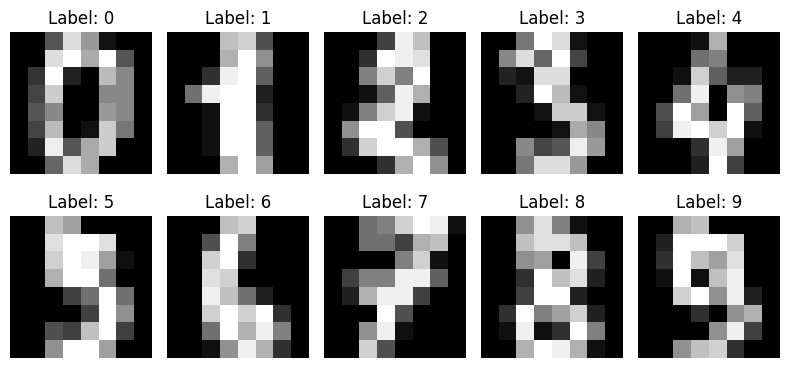

In [ ]:
digits = load_digits()
X = digits.data.astype(np.float32) / 16.0   # scale to [0,1]
y = digits.target.astype(np.int64)

print("Dataset:", X.shape, "Classes:", len(np.unique(y)))

# show class distribution
unique, counts = np.unique(y, return_counts=True)
print("\nClass distribution:")
for u, c in zip(unique, counts):
    print(f"Digit {u}: {c}")

# show a few samples
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap="gray")
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
#Train / Dev / Test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)
X_train, X_dev, y_train, y_dev = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=seed, stratify=y_temp
)

print("\nSplit shapes:")
print("Train:", X_train.shape, "Dev:", X_dev.shape, "Test:", X_test.shape)


Split shapes:
Train: (1077, 64) Dev: (360, 64) Test: (360, 64)


In [ ]:
#Standardize features (for NN + SVM)
scaler = StandardScaler()
X_train_n = scaler.fit_transform(X_train).astype(np.float32)
X_dev_n   = scaler.transform(X_dev).astype(np.float32)
X_test_n  = scaler.transform(X_test).astype(np.float32)


Training Neural Network...
Epoch 01/15 | train_loss=0.3821 train_acc=0.940 | val_loss=0.4549 val_acc=0.922
Epoch 02/15 | train_loss=0.2040 train_acc=0.965 | val_loss=0.2838 val_acc=0.931
Epoch 03/15 | train_loss=0.1377 train_acc=0.981 | val_loss=0.2236 val_acc=0.953
Epoch 04/15 | train_loss=0.1017 train_acc=0.992 | val_loss=0.1932 val_acc=0.953
Epoch 05/15 | train_loss=0.0776 train_acc=0.994 | val_loss=0.1716 val_acc=0.956
Epoch 06/15 | train_loss=0.0615 train_acc=0.997 | val_loss=0.1608 val_acc=0.956
Epoch 07/15 | train_loss=0.0495 train_acc=0.997 | val_loss=0.1533 val_acc=0.964
Epoch 08/15 | train_loss=0.0407 train_acc=0.997 | val_loss=0.1486 val_acc=0.964
Epoch 09/15 | train_loss=0.0332 train_acc=0.998 | val_loss=0.1459 val_acc=0.967
Epoch 10/15 | train_loss=0.0272 train_acc=0.999 | val_loss=0.1403 val_acc=0.964
Epoch 11/15 | train_loss=0.0228 train_acc=0.999 | val_loss=0.1395 val_acc=0.964
Epoch 12/15 | train_loss=0.0189 train_acc=1.000 | val_loss=0.1363 val_acc=0.969
Epoch 13/15 

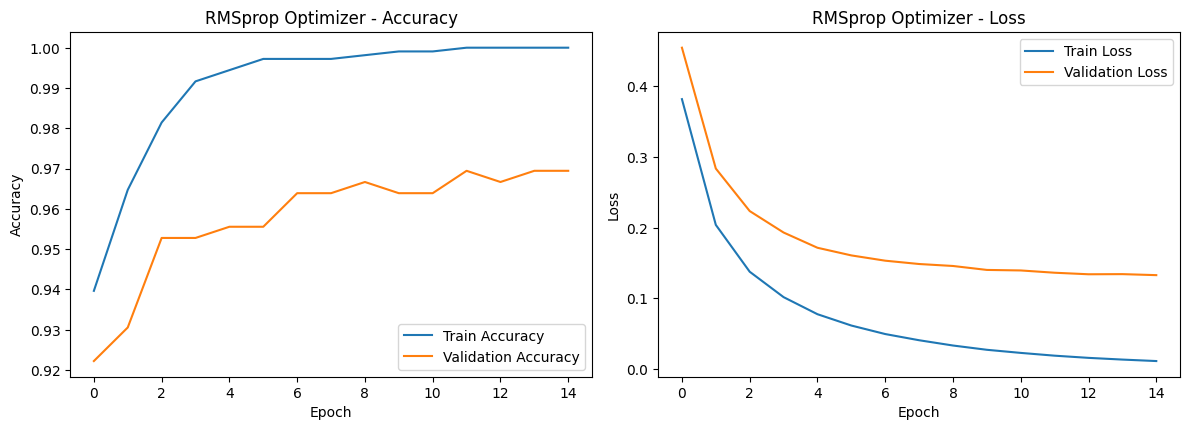

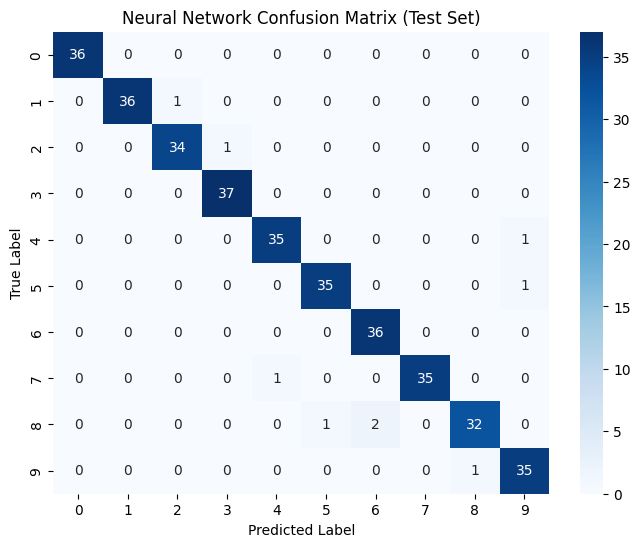

In [ ]:
#PyTorch 2-layer NN + Train/Val Curves

train_ds = TensorDataset(torch.tensor(X_train_n, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))
dev_ds   = TensorDataset(torch.tensor(X_dev_n, dtype=torch.float32),
                         torch.tensor(y_dev, dtype=torch.long))
test_ds  = TensorDataset(torch.tensor(X_test_n, dtype=torch.float32),
                         torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
dev_loader   = DataLoader(dev_ds, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

class TwoLayerNet(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=128, output_dim=10):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)  # logits
        return x

def eval_loss_acc(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * yb.size(0)
            pred = torch.argmax(logits, dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return total_loss / total, correct / total

# model
nn_model = TwoLayerNet(input_dim=64, hidden_dim=128, output_dim=10).to(device)
criterion = nn.CrossEntropyLoss()

# optimizer (choose one)
optimizer_name = "RMSprop"  # "Adam" or "RMSprop"
if optimizer_name == "Adam":
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)
else:
    optimizer = torch.optim.RMSprop(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 15
train_losses, dev_losses = [], []
train_accs, dev_accs = [], []

print("\nTraining Neural Network...")
for ep in range(1, epochs + 1):
    nn_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = nn_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    tr_loss, tr_acc = eval_loss_acc(nn_model, train_loader, criterion)
    dv_loss, dv_acc = eval_loss_acc(nn_model, dev_loader, criterion)

    train_losses.append(tr_loss)
    dev_losses.append(dv_loss)
    train_accs.append(tr_acc)
    dev_accs.append(dv_acc)

    print(f"Epoch {ep:02d}/{epochs} | train_loss={tr_loss:.4f} train_acc={tr_acc:.3f} | val_loss={dv_loss:.4f} val_acc={dv_acc:.3f}")

# Final NN test accuracy
nn_test_loss, nn_test_acc = eval_loss_acc(nn_model, test_loader, criterion)
print("\nNeural Network Test Accuracy:", nn_test_acc)

# ---- Plot curves (like your screenshot) ----
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(dev_accs, label="Validation Accuracy")
plt.title(f"{optimizer_name} Optimizer - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(dev_losses, label="Validation Loss")
plt.title(f"{optimizer_name} Optimizer - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# ---- NN Confusion Matrix ----
nn_model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = nn_model(xb)
        pred = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(pred)
        all_true.append(yb.numpy())

y_pred_nn = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

cm_nn = confusion_matrix(y_true, y_pred_nn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Neural Network Confusion Matrix (Test Set)")
plt.show()



**Task 3 (10 points)**: In task 2 describe how you selected the hyperparameters. What was the
rationale behind the technique you used? Did you use regularization? Why, or why not? Did you use
an optimization algorithm? Why or why not?

Hyperparameters were selected based on validation performance and training stability. The hidden layer size was chosen to balance model capacity and overfitting risk. A larger network slightly improved training accuracy but did not significantly improve validation accuracy, so a moderate size was selected.

The learning rate was tuned by observing convergence behavior. If the learning rate was too large, the loss fluctuated; if too small, convergence was slow. A stable value was selected based on smooth loss reduction on the validation set.

RMSprop was used as the optimization algorithm because it adapts the learning rate for each parameter and generally converges faster than standard gradient descent. Compared to basic SGD, RMSprop provided more stable validation performance.

Explicit regularization (e.g., L2 or dropout) was not heavily required because the dataset is small and the model capacity is limited. The validation accuracy tracked training accuracy, indicating minimal overfitting. Therefore, additional regularization was not necessary.

Overall, hyperparameters were selected using validation performance as the main criterion, focusing on convergence stability and generalization ability.

**Task 4 (100 points)**: Create another baseline model (can be any model we covered so far except
a deep learning model). Using the same training data (as above) train your model and evaluate
results using the test set. Compare the results of both models (the Neural Network and the
baseline model). What are the reasons for one model performing better (or not) than the
other? Explain.

I trained two baseline models using the same data split: Random Forest and SVM (RBF kernel).

* Neural Network: 97.5%

* Random Forest: 97.5%

* SVM-RBF: 98.06%

From the confusion matrices, all models perform very well, with only a few misclassifications among visually similar digits (e.g., 2, 8, and 9).

The SVM-RBF slightly outperforms the neural network. This is because:

* The Digits dataset is relatively small (1,797 samples), and classical models like SVM often perform well on small-to-medium datasets.

* The RBF kernel can capture nonlinear decision boundaries effectively without requiring large amounts of data.

* The neural network may slightly overfit, as training accuracy reached 100%, while validation accuracy plateaued.

Random Forest performs similarly to the neural network, suggesting that tree-based ensemble methods are strong baselines for structured tabular data like flattened image pixels.

For this dataset, traditional machine learning models (especially SVM-RBF) perform as well as or slightly better than the neural network. This suggests that deep learning does not always outperform classical methods, particularly when the dataset is small and low-dimensional.

Random Forest Test Accuracy: 0.975


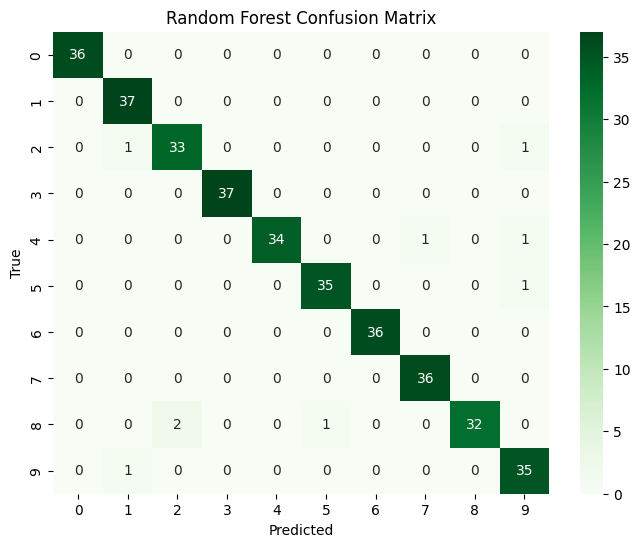

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Test Accuracy:", rf_acc)

cm_rf = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



Training SVM-RBF baseline...
SVM-RBF Test Accuracy: 0.9805555555555555


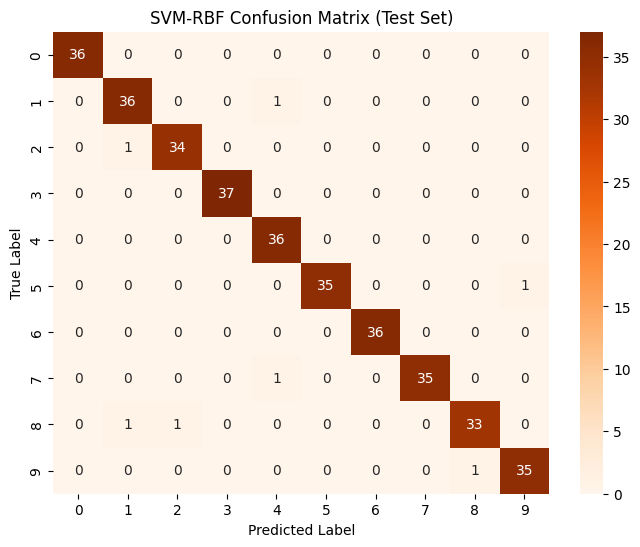

In [ ]:
# svm
run_svm = True
if run_svm:
    print("\nTraining SVM-RBF baseline...")
    svm = SVC(kernel="rbf", C=10, gamma="scale")
    svm.fit(X_train_n, y_train)

    svm_pred = svm.predict(X_test_n)
    svm_acc = accuracy_score(y_test, svm_pred)
    print("SVM-RBF Test Accuracy:", svm_acc)

    cm_svm = confusion_matrix(y_test, svm_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Oranges")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("SVM-RBF Confusion Matrix (Test Set)")
    plt.show()